In [1]:
# Load scenarios

%matplotlib inline

from collections import Counter, defaultdict
import glob
import gzip
import json
import math
from operator import itemgetter
import os
from pathlib import Path

from IPython.display import display, Markdown
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from pygtrie import StringTrie
import seaborn as sns

JS_CALIBRATION_RESULTS = Path("./js-benchmark-variance")
RS_SYNTHETIX_RESULTS = Path("./rs-benchmark-variance.txt")

In [2]:
js_data = defaultdict(list)

for filepath in glob.iglob(os.path.join(JS_CALIBRATION_RESULTS, "*.json")):
    total = 0
    with open(filepath) as f:
        measurements = json.load(f)
    for key, value in measurements.items():
        js_data["scenario"].append(key)
        js_data["timeMs"].append(value["timeMs"])
        total += value["timeMs"]
    js_data["scenario"].append("total")
    js_data["timeMs"].append(total)

js_df = pd.DataFrame(js_data)

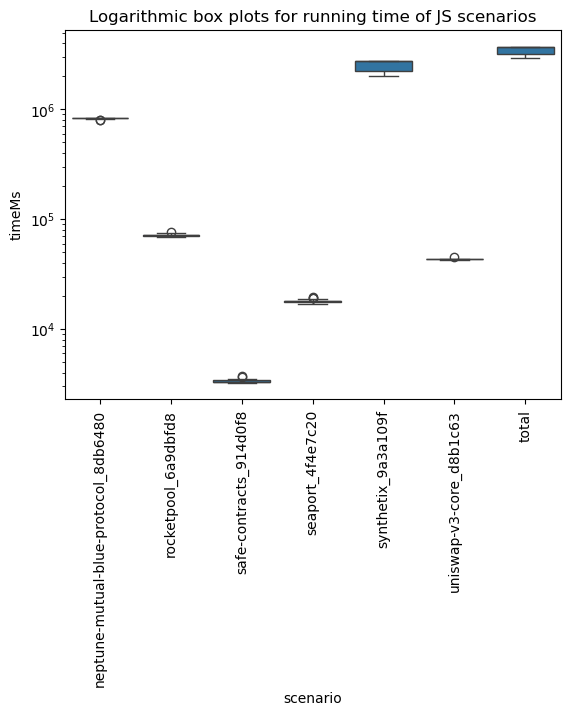

In [3]:
ax = sns.boxplot(x="scenario", y="timeMs", data=js_df)
ax.set(yscale="log")
ax.tick_params(axis='x', rotation=90)
_ = ax.set_title("Logarithmic box plots for running time of JS scenarios")

In [4]:
display(Markdown("Ratio of max/min time for each scenario in JS"))
js_df.groupby("scenario")["timeMs"].max() / js_df.groupby("scenario")["timeMs"].min()

Ratio of max/min time for each scenario in JS

scenario
neptune-mutual-blue-protocol_8db6480    1.044447
rocketpool_6a9dbfd8                     1.110794
safe-contracts_914d0f8                  1.141530
seaport_4f4e7c20                        1.148250
synthetix_9a3a109f                      1.378203
total                                   1.257722
uniswap-v3-core_d8b1c63                 1.044686
Name: timeMs, dtype: float64

In [5]:
import re

rs_data = defaultdict(list)
with open(RS_SYNTHETIX_RESULTS) as f:
    for line in f.readlines():
        m = re.match("Total time: (\d+)s", line)
        if m:
            rs_data["scenario"].append("synthetix_9a3a109f")
            rs_data["timeMs"].append(int(m[1]) * 1000)
rs_df = pd.DataFrame(rs_data)
display(Markdown("Ratio of max/min time for each scenario in RS"))
rs_df.groupby("scenario")["timeMs"].max() / rs_df.groupby("scenario")["timeMs"].min()

Ratio of max/min time for each scenario in RS

scenario
synthetix_9a3a109f    1.051809
Name: timeMs, dtype: float64

In [6]:
js_snapshot_data = defaultdict(list)

for filepath in glob.iglob(os.path.join(JS_CALIBRATION_RESULTS, "*.json")):
    with open(filepath) as f:
        measurements = json.load(f)
    for key, value in measurements.items():
        js_snapshot_data["scenario"].append(key)
        js_snapshot_data["failureCount"].append(len(value["failures"]))

js_snapshot_df = pd.DataFrame(js_snapshot_data)
js_snapshot_df.groupby("scenario").describe()

failureCount                           \
                                            count          mean        std   
scenario                                                                     
neptune-mutual-blue-protocol_8db6480         30.0    554.466667  18.546741   
rocketpool_6a9dbfd8                          30.0    390.000000   0.000000   
safe-contracts_914d0f8                       30.0    193.000000   0.000000   
seaport_4f4e7c20                             30.0    305.000000   0.000000   
synthetix_9a3a109f                           30.0  10264.000000   0.000000   
uniswap-v3-core_d8b1c63                      30.0    172.000000   0.000000   

                                                                            \
                                          min       25%      50%       75%   
scenario                                                                     
neptune-mutual-blue-protocol_8db6480    518.0    543.25    559.0    574.25   
rocketpool_6a9dbfd8                     390.0    390.00    390.0    390.00   
safe-contracts_914d0f8                  193.0    193.00    193.0    193.00   
seaport_4f4e7c20                        305.0    305.00    305.0    305.00   
synthetix_9a3a109f                    10264.0  10264.00  10264.0  10264.00   
uniswap-v3-core_d8b1c63                 172.0    172.00    172.0    172.00   

                                               
                                          max  
scenario                                       
neptune-mutual-blue-protocol_8db6480    575.0  
rocketpool_6a9dbfd8                     390.0  
safe-contracts_914d0f8                  193.0  
seaport_4f4e7c20                        305.0  
synthetix_9a3a109f                    10264.0  
uniswap-v3-core_d8b1c63                 172.0

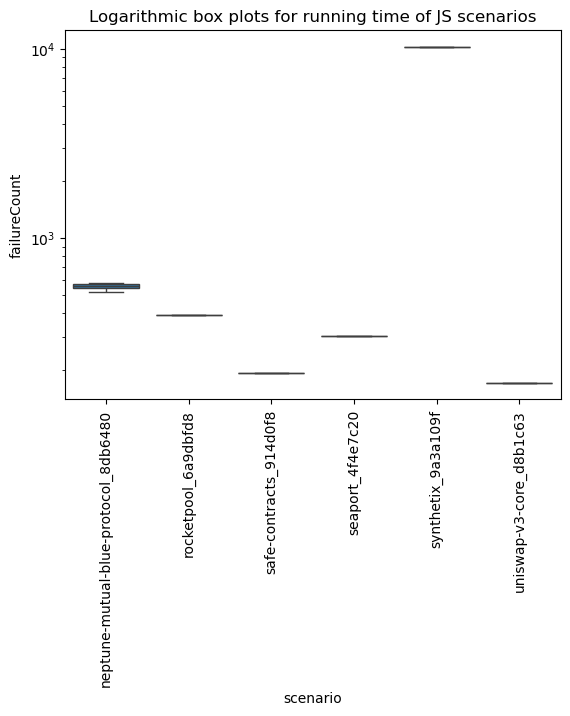

In [7]:
ax = sns.boxplot(x="scenario", y="failureCount", data=js_snapshot_df)
ax.set(yscale="log")
ax.tick_params(axis='x', rotation=90)
_ = ax.set_title("Logarithmic box plots for running time of JS scenarios")

In [8]:
FAILURES_FILE = "../js/benchmark/oz-new.json"
# FAILURES_FILE = "../js/benchmark/out.json"
# FAILURES_FILE = "../js/benchmark/neptune-patched.json"

failures_data = defaultdict(list)
with open(FAILURES_FILE) as f:
    for line in f.readlines():
        try:
            item = json.loads(line)
            failures_data["scenario"].append(item["name"])
            failures_data["failureCount"].append(len(item["result"]["failures"]))
            failures_data["failures"].append(item["result"]["failures"])
        except json.JSONDecodeError:
            pass

failures_df = pd.DataFrame(failures_data)
failures_df.groupby("scenario").describe()

failureCount                                 \
                                       count         mean       std     min   
scenario                                                                      
openzeppelin-contracts_0a5fba7a         33.0  1643.666667  1.963203  1640.0   

                                                                 
                                    25%     50%     75%     max  
scenario                                                         
openzeppelin-contracts_0a5fba7a  1642.0  1643.0  1645.0  1647.0

In [9]:
failure_counts = defaultdict(lambda: defaultdict(int))

for index, row in failures_df.iterrows():
    s = row["scenario"]
    for f in row["failures"]:
        failure_counts[s][f] += 1
        
failure_indices = defaultdict(list)
for s in failure_counts:
    for f, c in failure_counts[s].items():
        failure_indices["scenario"].append(s)
        failure_indices["index"].append(f)
        failure_indices["count"].append(c)

failure_indicies_df = pd.DataFrame(failure_indices)
failure_indicies_df.groupby("scenario")["count"].max()

scenario
openzeppelin-contracts_0a5fba7a    33
Name: count, dtype: int64

In [10]:
max_count_indices = failure_indicies_df.groupby("scenario")["count"].transform("max") == failure_indicies_df["count"]
varying_failure_counts = failure_indicies_df[~max_count_indices]
vfc = varying_failure_counts

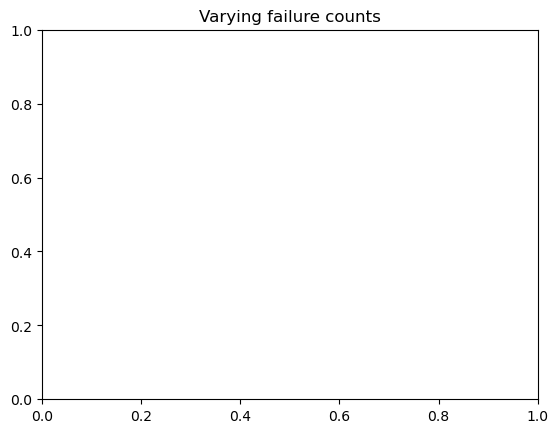

In [11]:
ax = sns.countplot(vfc[vfc["scenario"] == "openzeppelin-contracts_8b12f83a"], x="count", hue="scenario", stat="count")
_ = ax.set_title("Varying failure counts")

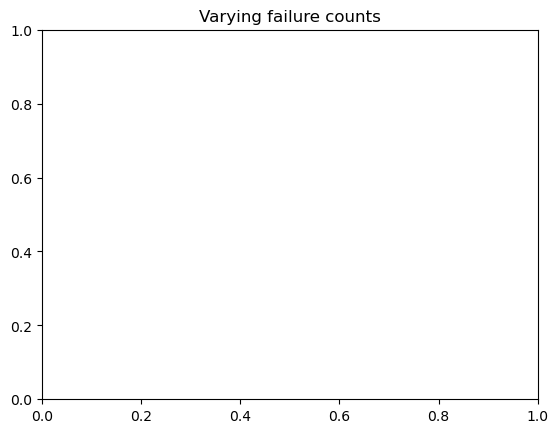

In [12]:
ax = sns.countplot(vfc[vfc["scenario"] == "neptune-mutual-blue-protocol_8db6480"], x="count", hue="scenario", stat="count")
_ = ax.set_title("Varying failure counts")

In [13]:
SCENARIO_DIR = Path("../scenarios")

rpc_calls = defaultdict(list)
scenario_configs = {}

for scenario in SCENARIO_DIR.glob("*.gz"):
    name = scenario.name.split(".")[0]
    if "openzeppelin" in name or "neptune" in name:
        with gzip.open(scenario) as f:
            for i, line in enumerate(f.readlines()):
                item = json.loads(line)
                if i == 0:
                    scenario_configs[name] = item
                else:
                    rpc_calls[name].append(item)

In [14]:
varying_rpc_calls = defaultdict(list)

for index, row in vfc.iterrows():
    s = row["scenario"]
    i = row["index"]
    c = row["count"]
    varying_rpc_calls["scenario"].append(s)
    varying_rpc_calls["method"].append(rpc_calls[s][i]["method"])
    varying_rpc_calls["count"].append(c)

vrc = pd.DataFrame(varying_rpc_calls)

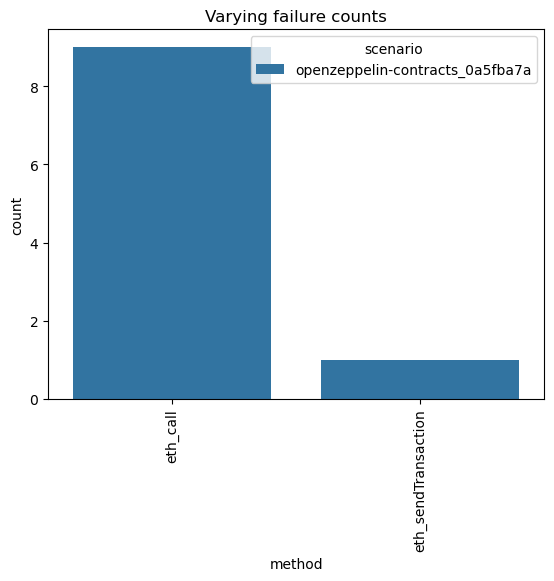

In [15]:
ax = sns.countplot(vrc, x="method", hue="scenario", stat="count")
ax.tick_params(axis='x', rotation=90)
_ = ax.set_title("Varying failure counts")

In [16]:
prev_methods = defaultdict(list)

for index, row in vfc.iterrows():
    s = row["scenario"]
    i = row["index"]
    prev_methods["scenario"].append(s)
    for j in range(1, 4):
        k = f"prev_{j}_method"
        if i - j < 0:
            prev_methods[k].append(None)
        else:
            prev_methods[k].append(rpc_calls[s][i-j]["method"])

prev_methods_df = pd.DataFrame(prev_methods)

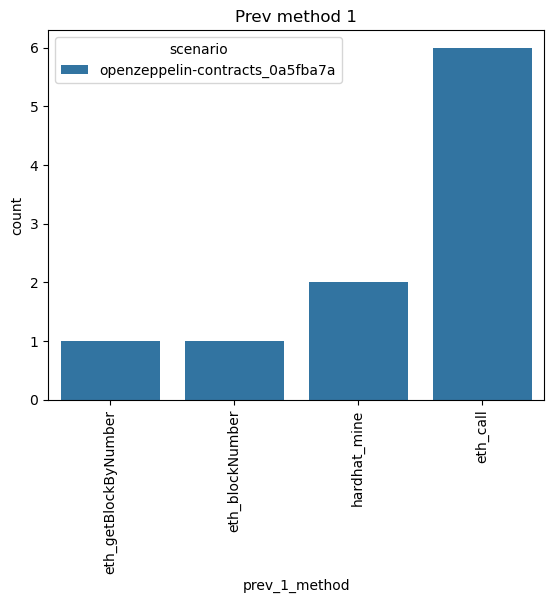

In [17]:
ax = sns.countplot(prev_methods_df, x="prev_1_method", hue="scenario", stat="count")
ax.tick_params(axis='x', rotation=90)
_ = ax.set_title("Prev method 1")

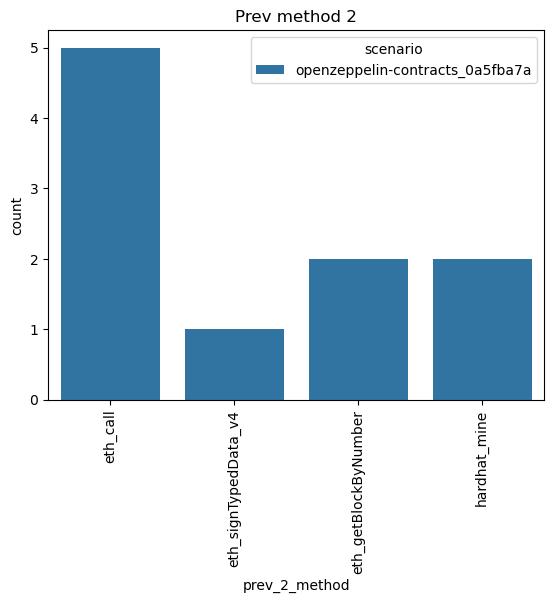

In [18]:
ax = sns.countplot(prev_methods_df, x="prev_2_method", hue="scenario", stat="count")
ax.tick_params(axis='x', rotation=90)
_ = ax.set_title("Prev method 2")

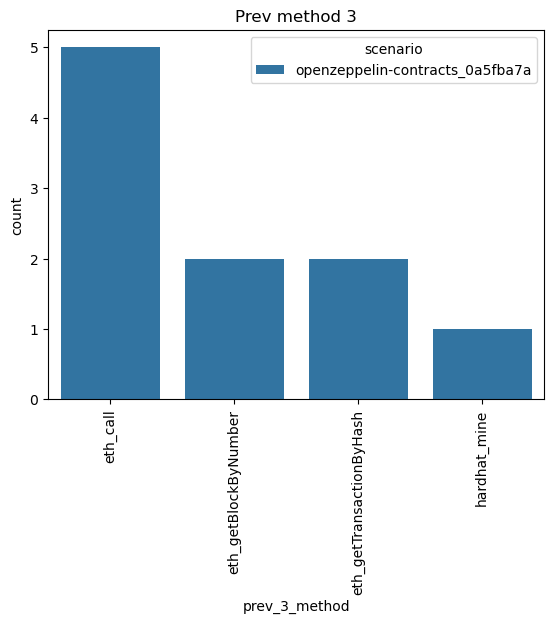

In [19]:
ax = sns.countplot(prev_methods_df, x="prev_3_method", hue="scenario", stat="count")
ax.tick_params(axis='x', rotation=90)
_ = ax.set_title("Prev method 3")